# Assignment 5

<font color=magenta>__Novel sentiment analysis__</font>

*zuzan*

In [1]:
import requests
from  bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from nltk import bigrams
import itertools
import networkx as nx
from itertools import combinations

#### Getting book text divided into chapters and pages

I picked *Adventures of Sherlock Holmes*!

In [2]:
r = requests.get('http://www.gutenberg.org/files/48320/48320-h/48320-h.htm')
soup = BeautifulSoup(r.content, 'html.parser')
book = soup.find_all(['h2','p'])  # I can split the book into chapters by h2

In [3]:
chapter_tags = book[9:]  # starting from 1st chapter

In [4]:
chapters = [''] * 12
i = -1
for chapter_tag in chapter_tags:
    if chapter_tag.name == 'h2':
        i += 1
    if chapter_tag.name == 'p':
        if chapter_tag.text == 'THE END':
            break
        chapters[i] = str(chapters[i]) + ' ' + chapter_tag.text.replace("\r\n"," ").replace("”",'"').replace("“",'"').replace("’","'")

for chapter in chapters:
    print('     next\n' + str(chapter)[:30])

     next
 TO Sherlock Holmes she is alw
     next
 I HAD called upon my friend, 
     next
 "MY dear fellow," said Sherlo
     next
 WE were seated at breakfast o
     next
 WHEN I glance over my notes a
     next
 ISA WHITNEY, brother of the l
     next
 I HAD called upon my friend S
     next
 ON glancing over my notes of 
     next
 OF all the problems which hav
     next
 THE Lord St. Simon marriage, 
     next
 "HOLMES," said I, as I stood 
     next
 "TO the man who loves art for


In [5]:
book = soup.find_all(['a',{'class':'pagenum'}, 'p'])  # I can split the book into pages by a
#print(book)

In [6]:
page_tags = book[38:]  # starting from 1st page

In [7]:
page_tags[0].get('class')  # pages are tagged with 'pagenum'

['pagenum']

In [8]:
pages = [''] * 305
i = -1
for page_tag in page_tags:
    if page_tag.name == 'a':
        if page_tag.get('class') == ['pagenum']:
            i += 1
    if page_tag.name == 'p':
        if page_tag.text == 'THE END':
            break
        pages[i] = str(pages[i]) + ' ' + page_tag.text.replace("\r\n"," ").replace("”","").replace("“","").replace("’","'")

#for page in pages:
#    print('     next\n' + str(page)[:30])
print(pages[2])

 Wedlock suits you, he remarked. I think, Watson, that you have put on seven and a half pounds since I saw you. Seven! I answered. Indeed, I should have thought a little more. Just a trifle more, I fancy, Watson. And in practice again, I observe. You did not tell me that you intended to go into harness. Then, how do you know? I see it, I deduce it. How do I know that you have been getting yourself very wet lately, and that you have a most clumsy and careless servant girl? My dear Holmes, said I, this is too much. You would certainly have been burned, had you lived a few centuries ago. It is true that I had a country walk on Thursday and came home in a dreadful mess; but, as I have changed my clothes, I can't imagine how you deduce it. As to Mary Jane, she is incorrigible, and my wife has given her notice; but there, again, I fail to see how you work it out. He chuckled to himself and rubbed his long, nervous hands together. It is simplicity itself, said he; my eyes tell me that on the 

So, I have two variables stroing chapters and pages of the book.

#### Counting characters

I assumed first it is about counting letters. I am not interested in foreign letters or punctuations.

In [9]:
def count_characters(par):
    letters = {'a':0, 'b':0, 'c':0, 'd':0, 'e':0, 'f':0, 'g':0, 'h':0, 'i':0, 'j':0, 'k':0, 'l':0, 'm':0, 'n':0, 'o':0,
               'p':0, 'q':0, 'r':0, 's':0, 't':0, 'u':0, 'v':0, 'w':0, 'x':0, 'y':0, 'z':0}
    text = par.lower()
    for char in text:
        if char in letters.keys():
            letters[char] += 1
    return(letters)              # function returns dictionary with english letters and number of their occurrences in the text

In [10]:
counted_per_chapter = []

for chapter in chapters:
    counted_per_chapter.append(count_characters(chapter))   # getting letter dictionary for each chapter

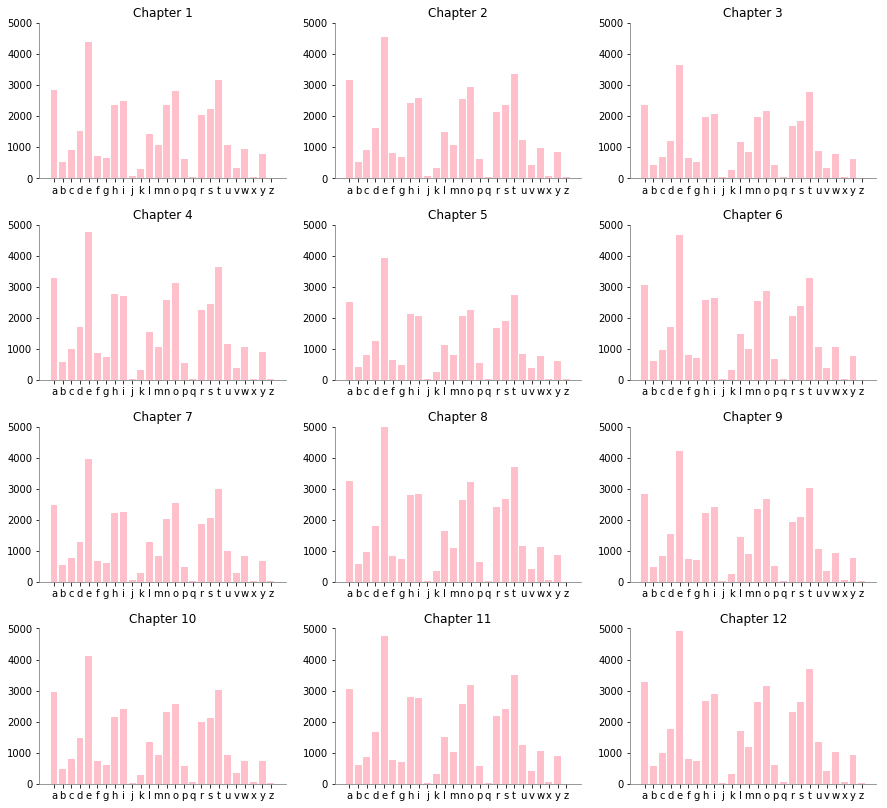

In [11]:
fig, axs = plt.subplots(4,3, figsize=(15, 14))

axs = axs.ravel()
i = 0
for D in counted_per_chapter:
    axs[i].bar(range(len(D)), list(D.values()), align='center', color='pink')
    axs[i].set_xticks(range(len(D)))
    axs[i].set_xticklabels(list(D.keys()))
    axs[i].set_title('Chapter {p}'.format(p=i+1))
    axs[i].set_ylim(0,5000)
    axs[i].spines['bottom'].set_color('0.5')
    axs[i].spines['top'].set_color(None)
    axs[i].spines['left'].set_color('0.5')
    axs[i].spines['right'].set_color(None)
    i += 1
plt.subplots_adjust(hspace = 0.3)
plt.show()
# Number of letter mentions per chapter

In [12]:
whole_book = ''
for chapter in chapters:
    whole_book = whole_book + chapter   # I want to have a text of whole book in one variable

In [14]:
len(whole_book)  # number of characters in whole book (including spaces, punctuation etc.)

559307

In [15]:
book_counted_characters = count_characters(whole_book)   # letter summary for whole book

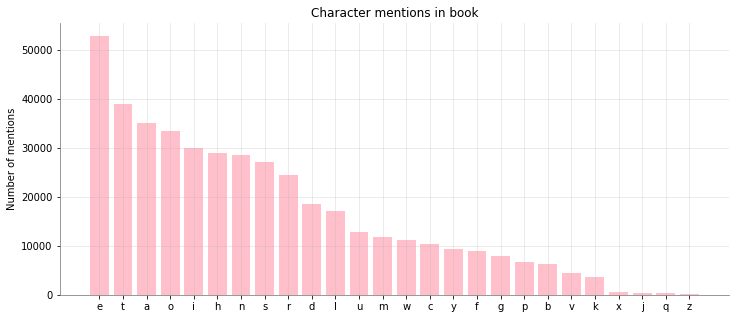

In [16]:
book_counted_sorted = sorted([[chars, counts] for chars, counts in book_counted_characters.items()], key = lambda x: x[1], reverse=True)
characters = [x[0] for x in book_counted_sorted]
counts = [x[1] for x in book_counted_sorted]

fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.bar(range(len(book_counted_characters)), counts, align = 'center', color='pink')
ax.set_xticks(range(len(book_counted_characters)))
ax.set_xticklabels(characters)
ax.set_title('Character mentions in book')
ax.set_ylabel('Number of mentions')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
plt.show()

*it starts with 'eta', so it's english!*

Number of sentences in the whole book.

In [17]:
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(whole_book)
sentences[:10]

[' TO Sherlock Holmes she is always the woman.',
 'I have seldom heard him mention her under any other name.',
 'In his eyes she eclipses and predominates the whole of her sex.',
 'It was not that he felt any emotion akin to love for Irene Adler.',
 'All emotions, and that one particularly, were abhorrent to his cold, precise, but admirably balanced mind.',
 'He was, I take it, the most perfect reasoning and observing machine that the world has seen; but, as a lover, he would have placed himself in a false position.',
 'He never spoke of the softer passions, save with a gibe and a sneer.',
 "They were admirable things for the observer—excellent for drawing the veil from men's motives and actions.",
 'But for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results.',
 'Grit in a sensitive instrument, or a crack in one of his own high-power lenses, would

In [18]:
len(sentences)

6804

In [19]:
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')   # let's try this tokenizer
sentences = tokenizer.tokenize(whole_book)

In [20]:
len(sentences)

6804

In [21]:
sentences[:10]    # seems like both tokenizers distinguish the sentences in the same way and there are no unclear sentence breaks

[' TO Sherlock Holmes she is always the woman.',
 'I have seldom heard him mention her under any other name.',
 'In his eyes she eclipses and predominates the whole of her sex.',
 'It was not that he felt any emotion akin to love for Irene Adler.',
 'All emotions, and that one particularly, were abhorrent to his cold, precise, but admirably balanced mind.',
 'He was, I take it, the most perfect reasoning and observing machine that the world has seen; but, as a lover, he would have placed himself in a false position.',
 'He never spoke of the softer passions, save with a gibe and a sneer.',
 "They were admirable things for the observer—excellent for drawing the veil from men's motives and actions.",
 'But for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results.',
 'Grit in a sensitive instrument, or a crack in one of his own high-power lenses, would

In [22]:
# Let's see the longest sentence
sentence_lengths = [len(sentence) for sentence in sentences]
print('The longest sentence has ' + str(max(sentence_lengths)) + ' characters.')
longest_sentence = sentences[sentence_lengths.index(max(sentence_lengths))]
print(longest_sentence)

The longest sentence has 563 characters.
"When you combine the ideas of whistles at night, the presence of a band of gypsies who are on intimate terms with this old doctor, the fact that we have every reason to believe that the doctor has an interest in preventing his step-daughter's marriage, the dying allusion to a band, and, finally, the fact that Miss Helen Stoner heard a metallic clang, which might have been caused by one of those metal bars which secured the shutters falling back into their place, I think that there is  good ground to think that the mystery may be cleared along those lines."


In [23]:
i = 1       # in which chapter is this sentence?
for chapter in chapters:
    if longest_sentence in chapter:
        print('Here it is! Chapter ' + str(i))
    i += 1

Here it is! Chapter 8


###### But those 'characters' are the people!

Firstly, I want to get a list of names and surnames of all characters in the book. In order to do it I checked all succesive pairs of words both classified as proper nouns. After this very first insight, I noticed many pairs starting with 'St.' etc. or ending with 'Street', 'Avenue', 'House' etc. Thus I included all those words in the function below to filter characters' names better.

In [24]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

text = whole_book.replace('"','').replace("‘","'").replace("—"," ")#.replace(";"," ").replace("?","").replace("!","")#.replace(",","").replace(".","")
words = []
tokenized = word_tokenize(text)
tagged = nltk.pos_tag(tokenized)

for i in range(len(tagged)-1):
    if (tagged[i][1] == 'NNP') & (tagged[i+1][1] == 'NNP'):
        if (tagged[i][0] not in ['Mr.','Miss','Mrs.','Dr.','St.','Sir','Stoke','Swandam','Lone','San',
                                 'Lord', 'Upper']) & (tagged[i+1][0] not in ['Street','Avenue', 'Garden','God','Von','Cross','Bank','Station',
                                'St.','Yard','Lodge','K.','Pool','Beeches','Square','Farm','Road','Court','Valley','League','Bridge',
                                'Klan','Cosmopolitan','House','Gate','Post','Spence']):
            words.append(tagged[i][0] + ' ' + tagged[i+1][0])


In [25]:
words

['TO Sherlock',
 'Sherlock Holmes',
 'Irene Adler',
 'Irene Adler',
 'Mary Jane',
 'Continental Gazetteer',
 'Von Kramm',
 'Wilhelm Gottsreich',
 'Gottsreich Sigismond',
 'Sigismond von',
 'von Ormstein',
 'Grand Duke',
 'Irene Adler',
 'Hebrew Rabbi',
 'New Jersey',
 'La Scala',
 'Imperial Opera',
 'Crown Prince',
 'Clotilde Lothman',
 'Lothman von',
 'von Saxe-Meningen',
 'Irene Adler',
 'Von Kramm',
 'Is Briony',
 'Irene Adler',
 'Irene Adler',
 'Godfrey Norton',
 'Inner Temple',
 'Godfrey Norton',
 'Godfrey Norton',
 'Irene Adler',
 'Godfrey Norton',
 'John Hare',
 'Sherlock Holmes',
 'Godfrey Norton',
 'Irene Adler',
 'Darlington Substitution',
 'Substitution Scandal',
 'Arnsworth Castle',
 'Mister Sherlock',
 'Sherlock Holmes',
 'Sherlock Holmes',
 'Irene Adler',
 'Sherlock Holmes',
 'Sherlock Holmes',
 'Irene Adler',
 'Sherlock Holmes',
 'Sherlock Holmes',
 'Sherlock Holmes',
 'Sherlock Holmes',
 'Irene Norton',
 'Sherlock Holmes',
 'Irene Adler',
 'Sherlock Holmes',
 'Mary Suth

There are still many trash names (opera name, initials, college name), but they appeared only once, so I decided to remove the entries which occured only once. It also deletes then a few characters, but I checked some of them and it seems like they were only briefly mentioned in the book (as a friend of a friend of a friend or someones grandma), so they are not really important.

In [26]:
characters_in_book = ['Watson','Lestrade']    # I add one important character who always appears with only surname
for name, number in Counter(words).most_common():
    if number > 1:
        characters_in_book.append(name)
characters_in_book                           # characters that appeared more than once in the book (there too many once mentioned names and they are not important)

['Watson',
 'Lestrade',
 'Sherlock Holmes',
 'Hosmer Angel',
 'Irene Adler',
 'Jabez Wilson',
 'Henry Baker',
 'Grimesby Roylott',
 'Duncan Ross',
 'Lysander Stark',
 'George Burnwell',
 'Mary Sutherland',
 'John Clay',
 'Colonel Lysander',
 'Godfrey Norton',
 'James Windibank',
 'John Openshaw',
 'Inspector Bradstreet',
 'Aloysius Doran',
 'Flora Millar',
 'James McCarthy',
 'Hugh Boone',
 'Vincent Spaulding',
 'William Crowder',
 'Hatty Doran',
 'Von Kramm',
 'Ezekiah Hopkins',
 'William Morris',
 'John Turner',
 'Major Prendergast',
 'Colonel Openshaw',
 'John Swain',
 'Isa Whitney',
 'John Horner',
 'James Ryder',
 'Catherine Cusack',
 'Helen Stoner',
 'Colonel Stark',
 'Lucy Parr',
 'Violet Hunter',
 'Spence Munro']

Now the mentions considering options: name / surname / name+surname   (I manually included a few restrictions after running this function first times when I noticed some inconsistency later)

In [27]:
def get_characters(text, names=characters_in_book):
    text = text.replace('"','').replace("‘","'").replace("—"," ")#.replace(";"," ").replace("?","").replace("!","")#.replace(",","").replace(".","")
    characters = []
    tokenized = word_tokenize(text)
    length = len(tokenized)
    names_and_surnames = word_tokenize(' '.join(names))   # list of all names and surnames together
    i = 0
    
    while i < length:
        #print(i)
        first_word = tokenized[i]
        #print(first_word)
        if (first_word in names_and_surnames) & (tokenized[i-1] not in ['St.']) : # if word in a list of names and surnames
            matching = [name for name in names if first_word in name]
            #print(matching)
            if len(matching) == 1:
                second_word = tokenized[i+1]
                #print(second_word)
                if first_word + ' ' + second_word == matching[0]:
                    i += 2
                else:
                    i += 1
                if (first_word + ' ' + second_word != 'Baker Street') & (first_word + ' ' + second_word != 'Inspector Barton'):
                    characters.append(matching[0])
            if len(matching) > 1:
                second_word = tokenized[i+1]
                #print(second_word)
                i += 2
                if any(first_word + ' ' + second_word in name for name in names):
                    characters.append(first_word + ' ' + second_word)
        else:
            i += 1
            
    return(characters)

In [28]:
characters_on_page = []
i=1
for page in pages:
    print(i)
    ch = get_characters(page)
    print(ch)
    characters_on_page.append(ch)
    i += 1

1
['Sherlock Holmes', 'Irene Adler', 'Irene Adler', 'Sherlock Holmes', 'Sherlock Holmes']
2
['Sherlock Holmes']
3
['Watson', 'Watson', 'Sherlock Holmes', 'Mary Sutherland']
4
[]
5
['Sherlock Holmes', 'Sherlock Holmes']
6
['Sherlock Holmes', 'Watson', 'Sherlock Holmes', 'Sherlock Holmes']
7
['Sherlock Holmes', 'Watson', 'Von Kramm', 'Sherlock Holmes', 'Sherlock Holmes', 'Sherlock Holmes']
8
['Sherlock Holmes', 'Sherlock Holmes', 'Sherlock Holmes', 'Sherlock Holmes', 'Irene Adler']
9
['Sherlock Holmes', 'Sherlock Holmes']
10
['Sherlock Holmes', 'Irene Adler']
11
['Sherlock Holmes', 'Von Kramm', 'Sherlock Holmes', 'Sherlock Holmes', 'Watson']
12
['Sherlock Holmes']
13
['Irene Adler', 'Irene Adler', 'Irene Adler', 'Godfrey Norton']
14
['Godfrey Norton']
15
['Watson', 'Godfrey Norton', 'Irene Adler', 'Godfrey Norton']
16
[]
17
['John Turner', 'Irene Adler']
18
['Sherlock Holmes', 'Sherlock Holmes', 'Sherlock Holmes', 'Godfrey Norton']
19
['Sherlock Holmes', 'Irene Adler']
20
['Sherlock Holm

In [29]:
characters_on_page_count = [dict(Counter(page_char)) for page_char in characters_on_page]

In [31]:
character_mentions_pro_page = {key: [] for key in characters_in_book}
character_mentions_pro_page

{'Aloysius Doran': [],
 'Catherine Cusack': [],
 'Colonel Lysander': [],
 'Colonel Openshaw': [],
 'Colonel Stark': [],
 'Duncan Ross': [],
 'Ezekiah Hopkins': [],
 'Flora Millar': [],
 'George Burnwell': [],
 'Godfrey Norton': [],
 'Grimesby Roylott': [],
 'Hatty Doran': [],
 'Helen Stoner': [],
 'Henry Baker': [],
 'Hosmer Angel': [],
 'Hugh Boone': [],
 'Inspector Bradstreet': [],
 'Irene Adler': [],
 'Isa Whitney': [],
 'Jabez Wilson': [],
 'James McCarthy': [],
 'James Ryder': [],
 'James Windibank': [],
 'John Clay': [],
 'John Horner': [],
 'John Openshaw': [],
 'John Swain': [],
 'John Turner': [],
 'Lestrade': [],
 'Lucy Parr': [],
 'Lysander Stark': [],
 'Major Prendergast': [],
 'Mary Sutherland': [],
 'Sherlock Holmes': [],
 'Spence Munro': [],
 'Vincent Spaulding': [],
 'Violet Hunter': [],
 'Von Kramm': [],
 'Watson': [],
 'William Crowder': [],
 'William Morris': []}

Finally, creating a dictionary of form {name: [list of mentions on each page], ...}

In [32]:
for key, value in character_mentions_pro_page.items():
    for page in characters_on_page_count:
        if key in page.keys():
            value.append(page[key])
        else:
            value.append(0)

In [33]:
def visualize_char_pro_page(name, dic=character_mentions_pro_page):
    fig, ax = plt.subplots(1,1, figsize=(17, 4))
    ax.bar(range(1,306), dic[name], align = 'center', color='pink')
    ax.set_title("'{name}' mentions pro page".format(name=name))
    ax.set_ylabel('Number of mentions')
    ax.set_xlabel('Page')
    ax.set_ylim(0,7)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color(None)
    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color(None)
    ax.grid(alpha=0.3)
    plt.show()

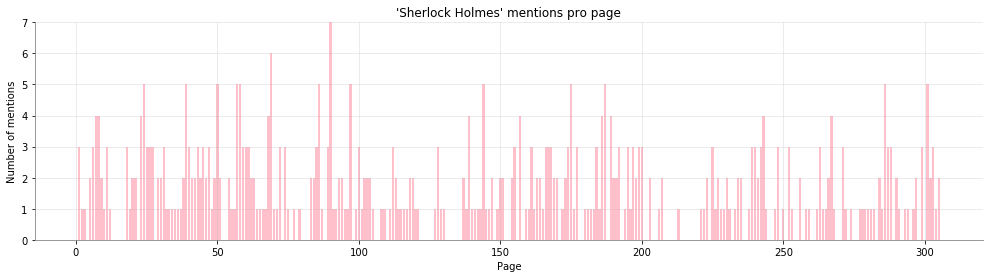

In [34]:
visualize_char_pro_page('Sherlock Holmes')

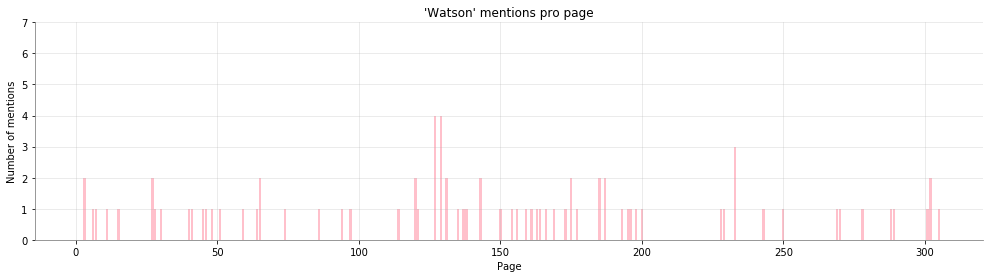

In [35]:
visualize_char_pro_page('Watson')

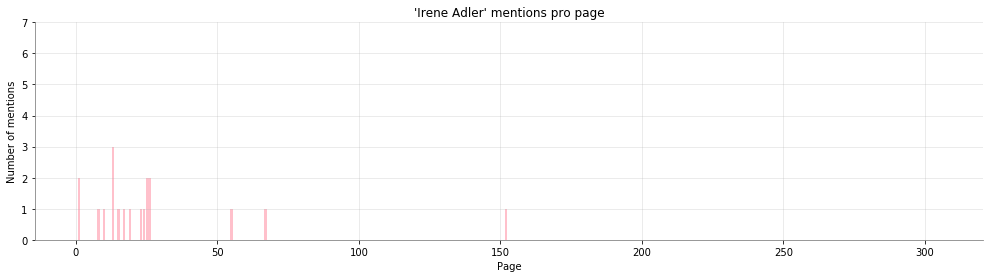

In [36]:
visualize_char_pro_page('Irene Adler')

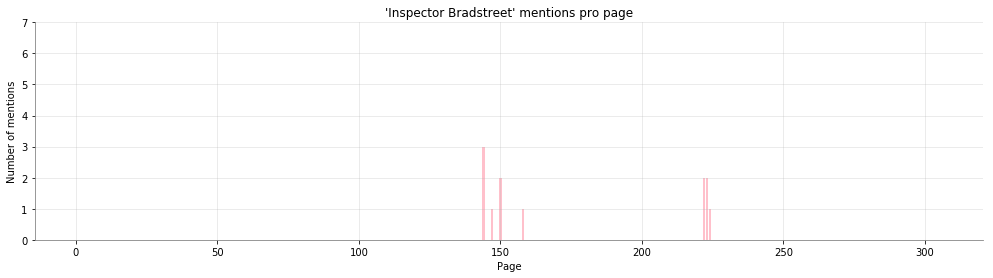

In [37]:
visualize_char_pro_page('Inspector Bradstreet') 

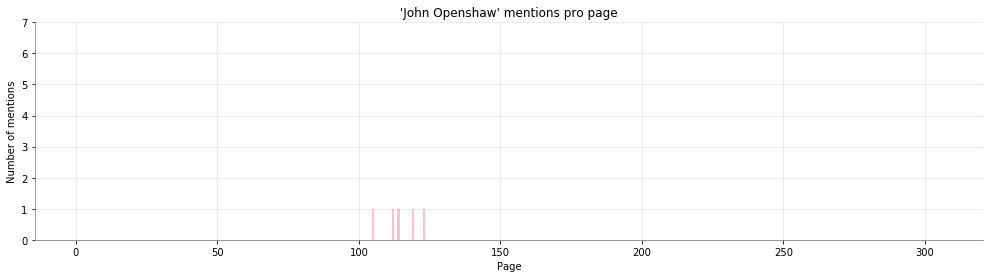

In [38]:
visualize_char_pro_page('John Openshaw')

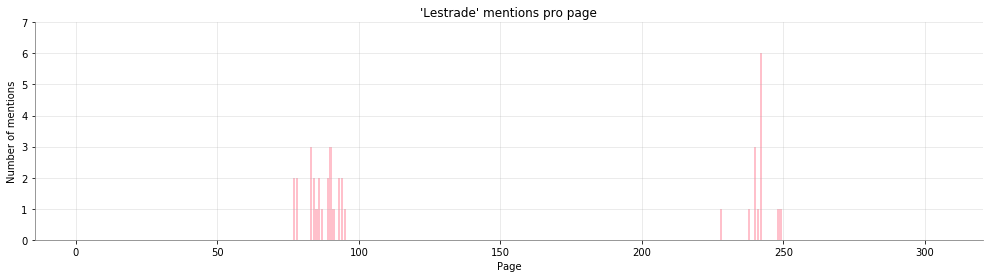

In [39]:
visualize_char_pro_page('Lestrade')

The same axis limits let us compare those barplots showing mentions pro page. We can see that Sherlock Holmes appears regularly and most often throughout the whole book. Dr. Watson was also an important person in the book. 

We can use this function for all other characters and see that most of them appear only in one chapter. It makes sense, since each chapter is another adventure.

#### Keywords

I created a function returning all nouns (lemmatized), because I considered that keywords can be only nouns.

In [40]:
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

# function counting word mentions in given text
def get_nouns(text):
    text = text.replace('"','').replace("‘","'").replace(":"," ").replace(";"," ").replace("?","").replace("!","")#.replace(",","").replace(".","")
    words = {}
    tokenized = word_tokenize(text)
    tagged = nltk.pos_tag(tokenized)
    lemmatizer = WordNetLemmatizer()   
    
    for word, tag in tagged:
        if tag.startswith('N'):      # which words can be considered as key words? nouns?
             wntag = wordnet.NOUN
        #elif tag.startswith('V'):
        #     wntag = wordnet.VERB
        #elif tag.startswith('J'):
        #     wntag = wordnet.ADJ
        #elif tag.startswith('R'):
        #     wntag = wordnet.ADV
        else:
             continue
        lemma = lemmatizer.lemmatize(word, pos=wntag)     # each word is lemmatized, to have its basics form
        
        if lemma in words.keys():
            words[lemma] += 1
        else:
            words[lemma] = 1
    return(words)

I sorted the nouns by number of their appearances.

In [41]:
words_book = get_nouns(whole_book)
keywords = sorted([[words, counts] for words, counts in words_book.items()], key = lambda x: x[1], reverse=True)

In [43]:
keywords[0:19]    # 20 keywords

[['Holmes', 453],
 ['man', 299],
 ['Mr.', 271],
 ['hand', 182],
 ['time', 168],
 ['room', 160],
 ['door', 147],
 ['matter', 144],
 ['case', 131],
 ['face', 127],
 ['day', 127],
 ['house', 120],
 ['way', 118],
 ['eye', 109],
 ['morning', 99],
 ['Sherlock', 96],
 ['window', 92],
 ['friend', 91],
 ['nothing', 91]]

They seem ok. Even 'Mr.' is quite a keyword, since it suggest the official tone of the book.

Keyword extraction with RAKE (Rapid Automatic Keyword Extraction)

Algorithm:
1. Word tokenize the text.
2. Split it into sequences by phrase delimeters and stop words (which are removed later).
3. The words from chosen sequences are scored basing on their co-occurrence matrix, as a ratio of number of co-occurrences to the number of occurrences.
4. Sort the list of candidates by their score.

In [44]:
from nltk.corpus import stopwords
import RAKE
Rake = RAKE.Rake(stopwords.words('english'))
Rake.run(whole_book, minCharacters = 4, maxWords = 1, minFrequency = 10)

[('to-night', 3.338461538461538),
 ('arm-chair', 3.265625),
 ('step-father', 2.930743243243243),
 ('sitting-room', 2.7838805970149254),
 ('step', 1.6875),
 ('sitting', 1.56),
 ('half', 1.4516129032258065),
 ('good', 1.4193548387096775),
 ('bell', 1.4),
 ('night', 1.3384615384615384),
 ('breakfast', 1.3333333333333333),
 ('chair', 1.265625),
 ('coat', 1.25),
 ('father', 1.2432432432432432),
 ('station', 1.2352941176470589),
 ('foot', 1.2307692307692308),
 ('written', 1.2272727272727273),
 ('room', 1.2238805970149254),
 ('lamp', 1.2105263157894737),
 ('water', 1.2),
 ('wedding', 1.2),
 ('police', 1.1935483870967742),
 ('table', 1.186046511627907),
 ('side', 1.1818181818181819),
 ('road', 1.1764705882352942),
 ('wood', 1.1666666666666667),
 ('fellow', 1.1666666666666667),
 ('important', 1.1666666666666667),
 ('daughter', 1.1578947368421053),
 ('rose', 1.1538461538461537),
 ('afternoon', 1.1538461538461537),
 ('cellar', 1.1538461538461537),
 ('paper', 1.1481481481481481),
 ('rooms', 1.1428

Quite an interesting result, words are totally different.

#### Sentiment analysis

In sentiment analysis it would be nice to teach an algorithm, basing on some training sentences, what are their sentiments. Then the algorithm can guess the sentiment of other sentences comparing words appearing there. But in order to do it I have to read a part of the book and manually classify the sentences (or paragraphs or something). I am too lazy to do it, so I decided to go more naive way. I assume that adjectives can say the most about the sentiment of the text. Thus first I wrote a function extracting adjectives from given text.

In [45]:
from nltk.corpus import stopwords

def get_adjectives(text):
    text = text.replace('"','').replace("‘","'").replace(":"," ").replace(";"," ").replace("?","").replace("!","").replace("\'","")#.replace(",","").replace(".","")
    words = {}
    tokenized = word_tokenize(text)
    tagged = nltk.pos_tag(tokenized)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')) 
    
    for word, tag in tagged:
        if tag.startswith('J') & (word not in stop_words):      
             wntag = wordnet.ADJ
        else:
             continue
        lemma = lemmatizer.lemmatize(word, pos=wntag)
        
        if lemma in words.keys():
            words[lemma] += 1
        else:
            words[lemma] = 1
    return(words)

Then I checked what are the most popular adjectives in the whole book.

In [46]:
adjectives_book = get_adjectives(whole_book)
sorted([[words, counts] for words, counts in adjectives_book.items()], key = lambda x: x[1], reverse=True)

[['little', 255],
 ['good', 122],
 ['last', 91],
 ['small', 82],
 ['young', 82],
 ['old', 73],
 ['much', 71],
 ['first', 68],
 ['great', 68],
 ['long', 62],
 ['right', 55],
 ['large', 50],
 ['possible', 49],
 ['black', 47],
 ['strange', 43],
 ['dear', 42],
 ['open', 41],
 ['clear', 40],
 ['strong', 39],
 ['whole', 38],
 ['many', 38],
 ['sure', 38],
 ['least', 34],
 ['deep', 31],
 ['able', 31],
 ['singular', 30],
 ['true', 29],
 ['heavy', 29],
 ['several', 29],
 ['red', 29],
 ['obvious', 29],
 ['new', 28],
 ['low', 27],
 ['high', 27],
 ['best', 26],
 ['white', 26],
 ['light', 26],
 ['second', 24],
 ['easy', 23],
 ['less', 22],
 ['present', 22],
 ['next', 22],
 ['likely', 22],
 ['gray', 22],
 ['poor', 21],
 ['considerable', 21],
 ['late', 20],
 ['bad', 20],
 ['remarkable', 20],
 ['quiet', 20],
 ['safe', 20],
 ['ready', 20],
 ['thin', 20],
 ['short', 20],
 ['extraordinary', 19],
 ['simple', 19],
 ['important', 19],
 ['interesting', 18],
 ['single', 18],
 ['serious', 18],
 ['ten', 18],
 ['

Observing this list I created two lists of adjectives which I consider positive and negative (same length).

In [47]:
positive_adj = ['good','great','dear','true','best','rich','safe','interesting','extraordinary',
                'happy','glad','excellent','precious','beautiful','correct','immense','nice','successful',
               'fantastic','perfect','fortunate','worth','useful','gentle','sweet','wonderful','neat',
                'positive','special','friendly','admirable','lucky','pretty']
negative_adj = ['bad','afraid','dreadful','poor','dead','wrong','terrible','horrible','weary',
               'angry','nervous','anxious','mad','sorry','unfortunate','evil','injured','painful',
               'fierce','dull','violent','weak','lonely','dangerous','unpleasant','sad','unable',
               'dirty','false','fatal','unhappy','miserable','foolish']

Then I compared for each chapter the extracted adjectives and those two lists. If there appeared a positive adjective it got +1 score, if there was a negative adjective it got -1 score. Summing those scores and dividing by number of all adjectives gives an estimated sentiment.

In [48]:
chapter_sentiment = []

for chapter in chapters:
    adjectives_chapter = get_adjectives(chapter)
    sentiment = 0
    number_of_polarized_words = 0
    for word, count in adjectives_chapter.items():
        if word in positive_adj:
            sentiment += count
            number_of_polarized_words += count
        if word in negative_adj:
            sentiment -= count
            number_of_polarized_words += count
    #chapter_sentiment.append(sentiment / number_of_polarized_words)
    chapter_sentiment.append(sentiment / sum(adjectives_chapter.values()))   # what to divide by? 

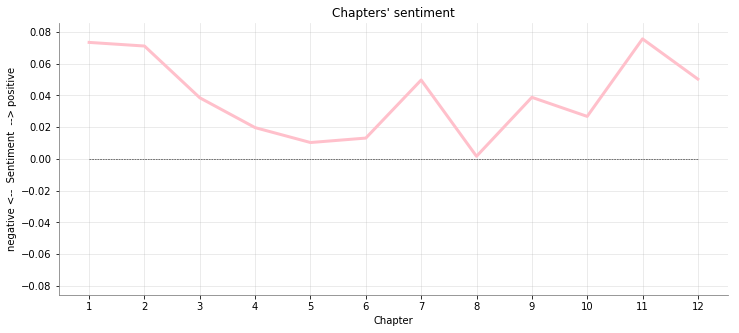

In [49]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
plt.plot(list(range(1,13)), chapter_sentiment, color='pink', linewidth=3)
plt.ylim((-max(chapter_sentiment)-.01, max(chapter_sentiment)+.01))
plt.plot(list(range(1,13)), [0]*12, 'k--', linewidth=0.5)
plt.xticks(list(range(1,13)))
plt.grid(alpha=0.3)
plt.xlabel('Chapter')
plt.ylabel('negative <--  Sentiment  --> positive')
plt.title("Chapters' sentiment")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.show()

As we can see, the book is rather positive than negative. The inner chapters are in general less positive than the first and last ones. It seems like there is a positive cumulation point in chapter 7, after which comes a breakdown in chapter 8. However it is still above 0.

I proceeded the same steps for pages.

In [50]:
page_sentiment = []

for page in pages:
    adjectives_page = get_adjectives(page)
    sentiment = 0
    number_of_polarized_words = 0
    for word, count in adjectives_page.items():
        if word in positive_adj:
            sentiment += count
            number_of_polarized_words += count
        if word in negative_adj:
            sentiment -= count
            number_of_polarized_words += count
    if number_of_polarized_words == 0:
        #page_sentiment.append(0)
        page_sentiment.append(sentiment / sum(adjectives_page.values()))
    else:
        #page_sentiment.append(sentiment / number_of_polarized_words)
        page_sentiment.append(sentiment / sum(adjectives_page.values()))

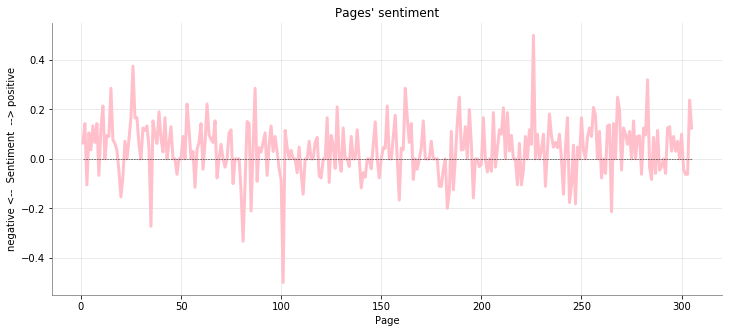

In [51]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
plt.plot(list(range(1,306)), page_sentiment, color='pink', linewidth=3)
plt.plot(list(range(1,306)), [0]*305, 'k--', linewidth=0.5)
plt.grid(alpha=0.3)
plt.xlabel('Page')
plt.ylabel('negative <--  Sentiment  --> positive')
plt.title("Pages' sentiment")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.show()

In [52]:
np.mean(page_sentiment)

0.03788114609383323

Here it is much less stable. On average the sentiment is positive, although ich changes from page to page.

In [53]:
pages[page_sentiment.index(min(page_sentiment))]

' James McCarthy was acquitted at the Assizes, on the strength of a number of objections which had been drawn out by Holmes, and submitted to the defending counsel. Old Turner lived for seven months after our interview, but he is now dead; and there is every prospect that the son and daughter may come to live happily together, in ignorance of the black cloud which rests upon their past.'

In [54]:
get_adjectives(pages[page_sentiment.index(min(page_sentiment))])

{'black': 1, 'dead': 1}

On this short page, for example, there are only two adjectives, one of them classified as negative. As we can see, some pages may not be the best to perform sentiment analysis in this way.

##### Using VADER

*VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.
VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.*

In [55]:
#nltk.downloader.download('vader_lexicon')

In [56]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

C:\Users\zuzan\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Here we have a function giving us a score of positivity, negativity and neutrality.

In [57]:
sid.polarity_scores(pages[0])

{'compound': 0.9888, 'neg': 0.091, 'neu': 0.75, 'pos': 0.159}

In [58]:
positive_score = []
negative_score = []
neutral_score = []

for chapter in chapters:
    s = sid.polarity_scores(chapter)
    positive_score.append(s['pos'])
    negative_score.append(s['neg'])
    neutral_score.append(s['neu'])

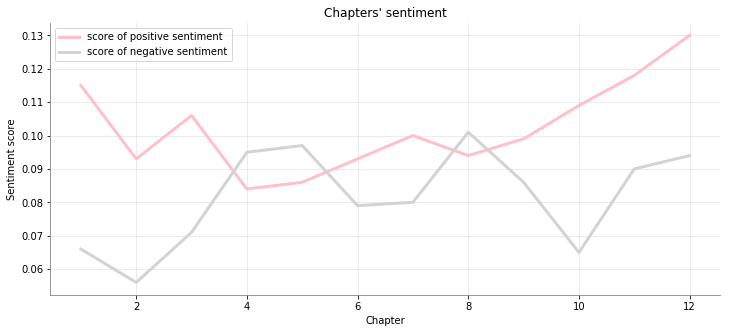

In [59]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
plt.plot(list(range(1,13)), positive_score, color='pink', linewidth=3)
plt.plot(list(range(1,13)), negative_score, color='lightgrey', linewidth=3)
#plt.plot(list(range(1,13)), [0]*12, 'k--', linewidth=0.5)
plt.grid(alpha=0.3)
plt.xlabel('Chapter')
plt.ylabel('Sentiment score')
plt.title("Chapters' sentiment")
ax.legend(['score of positive sentiment','score of negative sentiment'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.show()

I wanted to present both lines (more informative). If we compare it with the previous plot, it is similar that in 5th and 8th there is a little breakdown. Did something happen then?...

In [60]:
positive_score = []
negative_score = []
neutral_score = []

for page in pages:
    s = sid.polarity_scores(page)
    positive_score.append(s['pos'])
    negative_score.append(s['neg'])
    neutral_score.append(s['neu'])

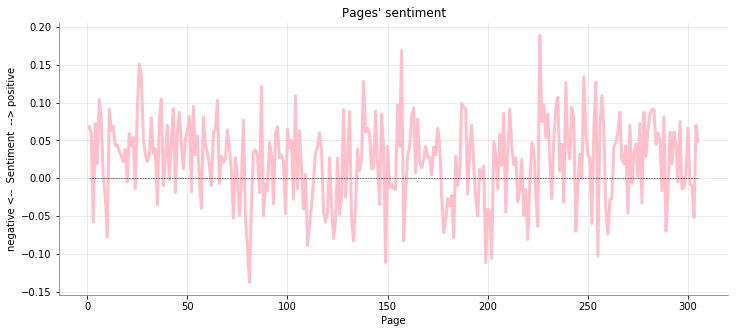

In [61]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
plt.plot(list(range(1,306)), np.array(positive_score)-np.array(negative_score), color='pink', linewidth=3)
plt.plot(list(range(1,306)), [0]*305, 'k--', linewidth=0.5)
plt.grid(alpha=0.3)
plt.xlabel('Page')
plt.ylabel('negative <--  Sentiment  --> positive')
plt.title("Pages' sentiment")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.show()

Here I combined both scores to present a sentiment rate with neutrality in zero. Again, it is not stable, but on average a bit more positive than negative.

#### Co-occurrences in chapters

In this analysis I am interested in all the nouns, verbs, adjectives and adverbs which can form a collocation or other important pair of words. The function below creates a list of ordered lemmatized words (omitting stop words or other parts of speech).

In [62]:
def get_words(text):
    text = text.replace('"','').replace("‘","'").replace(":"," ").replace(";"," ").replace("?","").replace("!","")#.replace(",","").replace(".","")
    words = []
    tokenized = word_tokenize(text)
    tagged = nltk.pos_tag(tokenized)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    stop_words.add("n't")
    
    for word, tag in tagged:
        if word in stop_words:
            continue
        if tag.startswith('N'):      
            wntag = wordnet.NOUN
        elif tag.startswith('V'):
            wntag = wordnet.VERB
        elif tag.startswith('J'):
            wntag = wordnet.ADJ
        elif tag.startswith('R'):
            wntag = wordnet.ADV
        else:
            continue
        lemma = lemmatizer.lemmatize(word, pos=wntag)
        words.append(lemma)
    return(words)

In [63]:
# this function counts the number of mentions of pairs of words and creates a graph for given text
def cooccur_graph(text, how_many, chapter_number):
    tokens = get_words(text)
    bigram = list(bigrams(tokens))
    bigram_counts = Counter(bigram)
    bigram_df = pd.DataFrame(bigram_counts.most_common(how_many),
                             columns=['bigram', 'count'])
    
    d = bigram_df.set_index('bigram').T.to_dict('records')
    
    G = nx.Graph()

    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=v)

    degree = dict(G.degree)

    plt.figure(figsize = (18,10)) 
    pos = nx.spring_layout(G, k=3, iterations=100)
    #pos = nx.spectral_layout(G)
    edge_width = [G[i][j]['weight']/5 for i,j in G.edges()]
    nx.draw(G, pos, font_size=15,
                     width=edge_width,
                     edge_color='grey', node_color='pink',
                     with_labels = True, 
                     nodelist=degree.keys(), node_size=[v * 300 for v in degree.values()])
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, font_size = 9)
    plt.title("Co-occurrences in chapter {p}".format(p=chapter_number), fontdict = {'fontsize' : 30})
    plt.show()

Chapter 1

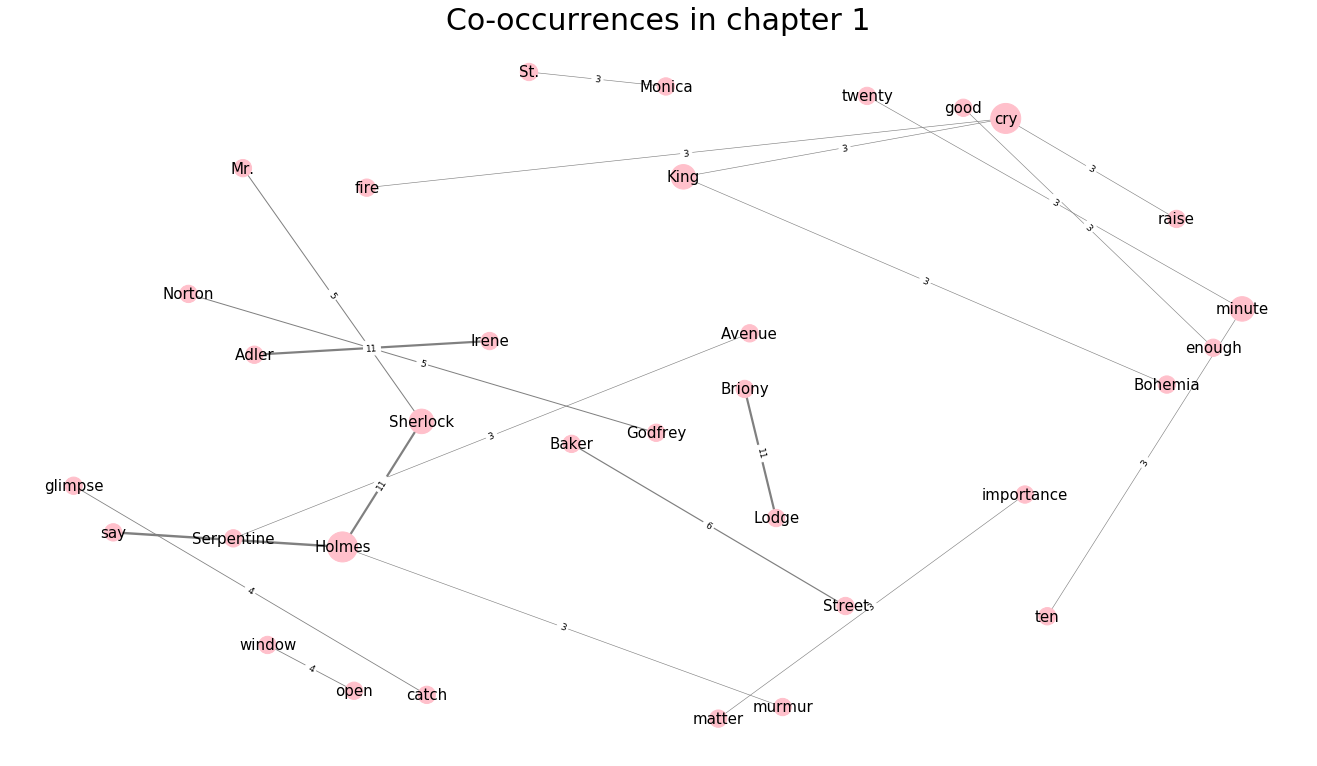

In [64]:
cooccur_graph(chapters[0],20,1)

We can see that the most frequent pair is 'Holmes' and 'say', usually used in form 'Holmes said'. The next is 'Sherlock Holmes' (quite obvious) and 'Briony Lodge'. If we scan the book looking for this words, we will find that >>It is a bijou villa, with a garden at the back, but built out in front right up to the road, two stories.<< and this name appears only in the first chapter. In the graph we can notice also some characters names, like Irene Adler, Godfrey Norton or King of Bohemia. There is also Baker Street visible here, but if we scan the whole book, this name should appear throughout it regularly.

Chapter 2

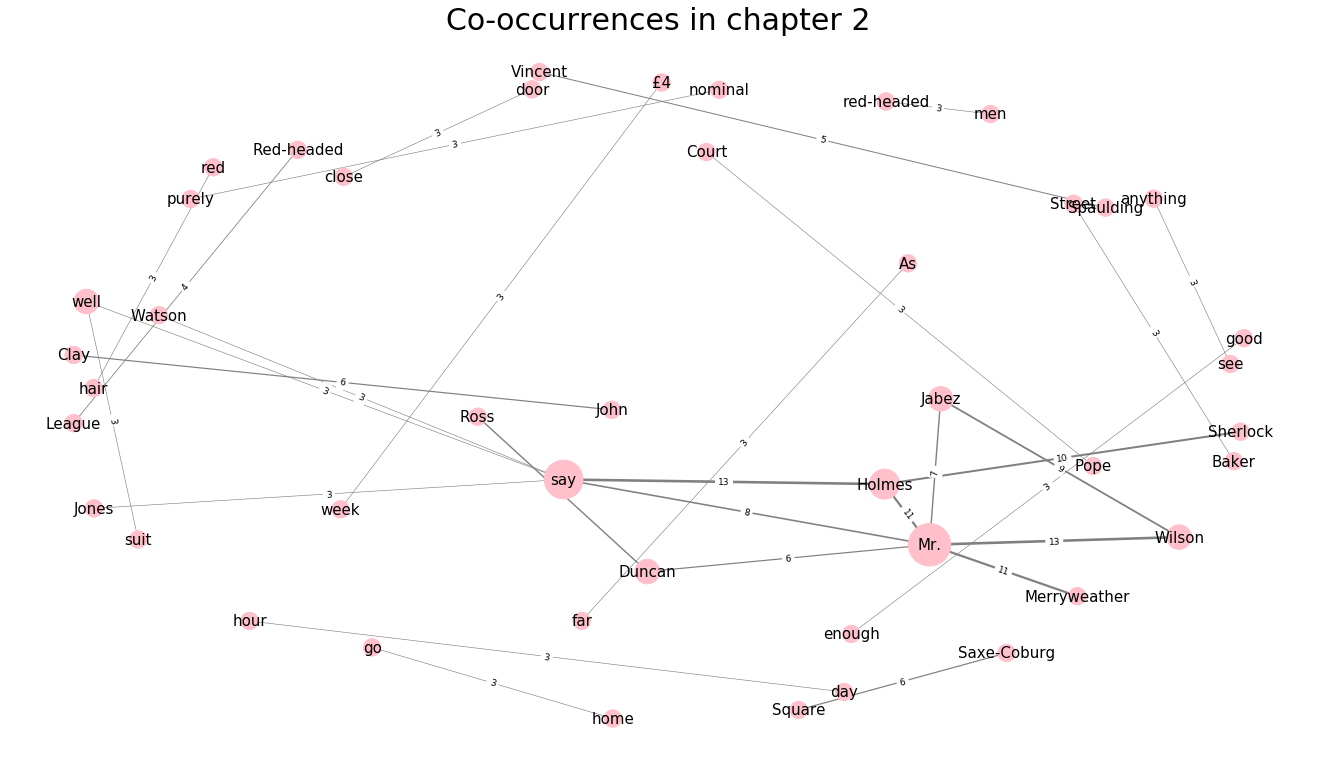

In [65]:
cooccur_graph(chapters[1],30,2)

If we take a look at 30 most frequent pairs, we will find the Baker Street as supposed! However, returning to most frequent ones...  Mr. Holmes of course, and other characters in this chapter: Jabez Wilson, Mr. Merryweather. Also only in this chapter appears John Clay, Vincent Spaulding, (Peter) Jones and Duncan Ross. Quite popular is also 'Red-headed League' and 'red-headed men'. Other pairs are rather just popular combinations of popular words, like 'closed the door', 'good enough', 'went home'.

Chapter 3

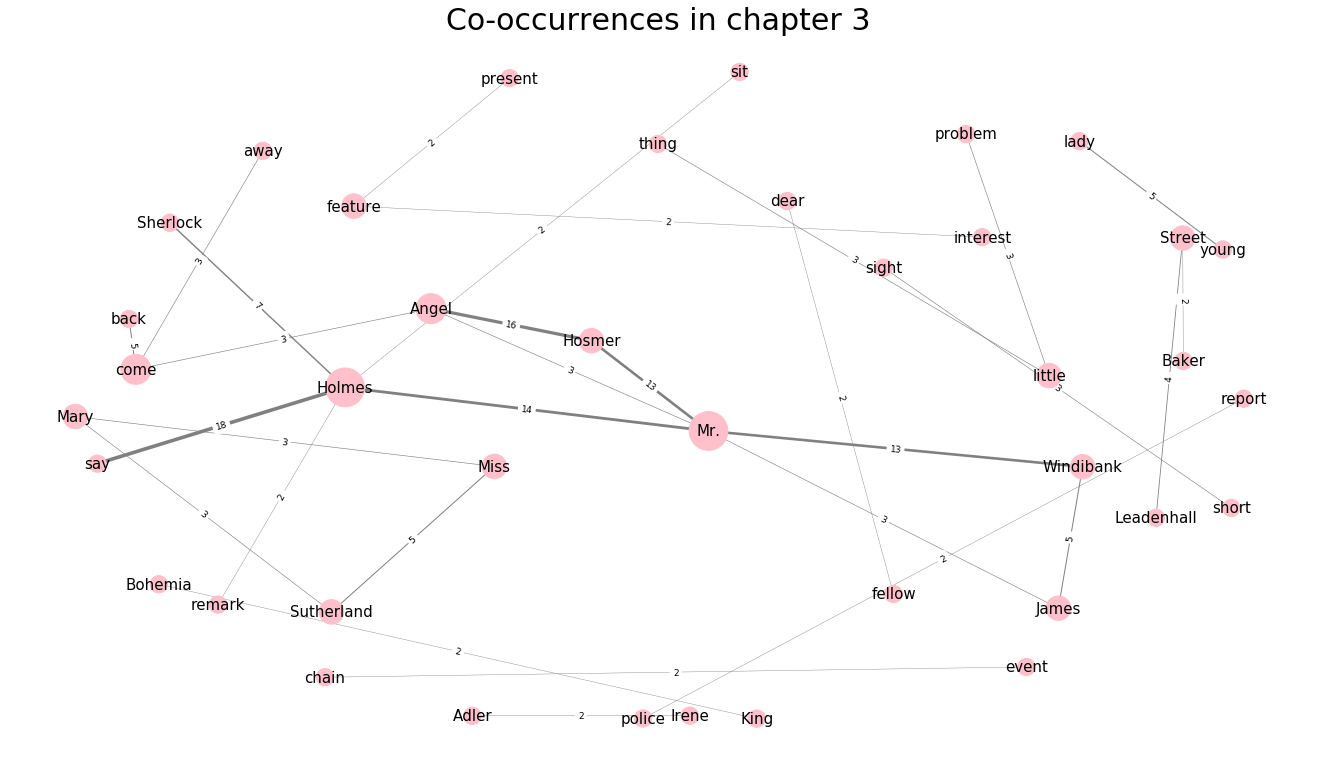

In [66]:
cooccur_graph(chapters[2],30,3)

By repeating such analysis for other chapters we can capture the characters names and see that there are new people (and new adventure) in every chapter.

##### Co-occurrences of characters on the same page

In [67]:
who_together = [list(set(ch)) for ch in characters_on_page if ch]  # names on each page (excluding pages with no name)
who_together

[['Sherlock Holmes', 'Irene Adler'],
 ['Sherlock Holmes'],
 ['Watson', 'Mary Sutherland', 'Sherlock Holmes'],
 ['Sherlock Holmes'],
 ['Watson', 'Sherlock Holmes'],
 ['Watson', 'Sherlock Holmes', 'Von Kramm'],
 ['Sherlock Holmes', 'Irene Adler'],
 ['Sherlock Holmes'],
 ['Sherlock Holmes', 'Irene Adler'],
 ['Watson', 'Sherlock Holmes', 'Von Kramm'],
 ['Sherlock Holmes'],
 ['Godfrey Norton', 'Irene Adler'],
 ['Godfrey Norton'],
 ['Watson', 'Godfrey Norton', 'Irene Adler'],
 ['John Turner', 'Irene Adler'],
 ['Sherlock Holmes', 'Godfrey Norton'],
 ['Sherlock Holmes', 'Irene Adler'],
 ['Sherlock Holmes'],
 ['Sherlock Holmes'],
 ['Sherlock Holmes', 'Irene Adler'],
 ['Sherlock Holmes', 'Godfrey Norton', 'Irene Adler'],
 ['Sherlock Holmes', 'Godfrey Norton', 'Irene Adler'],
 ['Sherlock Holmes', 'Irene Adler'],
 ['Watson', 'Jabez Wilson', 'Sherlock Holmes'],
 ['Mary Sutherland', 'Watson', 'Jabez Wilson'],
 ['Jabez Wilson', 'Sherlock Holmes'],
 ['Jabez Wilson',
  'Ezekiah Hopkins',
  'Sherlock Ho

In [68]:
char_counter = dict(Counter([item for sublist in who_together for item in sublist]))

In [69]:
G = nx.Graph()
for one_page in who_together:
    if len(one_page) > 1: 
        edges = list(combinations(one_page, 2))   # possible combinations of pairs of characters mentioned on one page

        for i,j in edges:  
            if (i,j) in G.edges() or (j,i) in G.edges():   # adding weight to the edge, if exists
                G[i][j]['weight'] += 1    
            else:
                G.add_edge(i, j, weight = 1)   # creating edge between characters, if it does not exist yet

    elif one_page[0] not in G.nodes():  # if there is a single character, creating node for them, if it does not exist yet
        G.add_node(one_page[0])

In [70]:
sizes = [char_counter[name]*25 for name in list(G.nodes)]

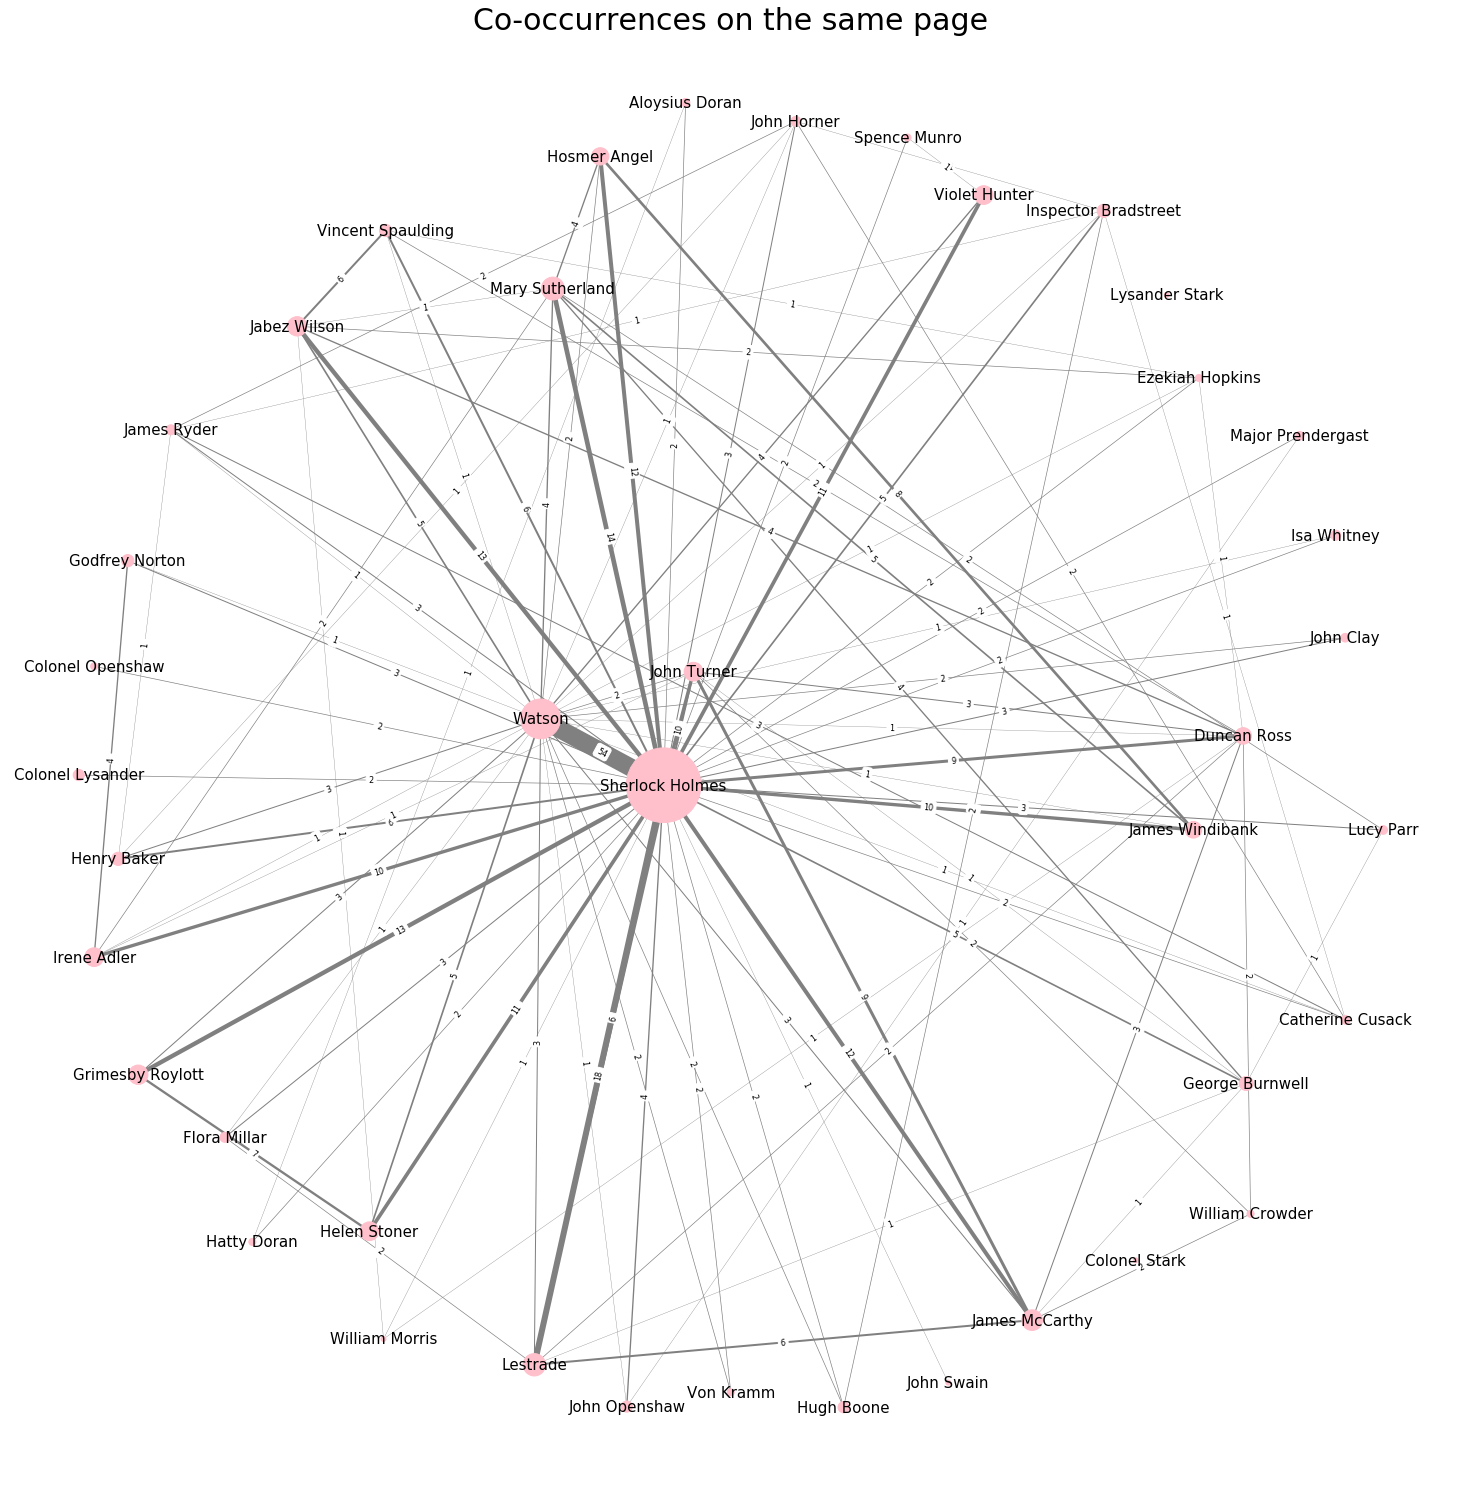

In [71]:
plt.figure(figsize = (20,20)) 
pos = nx.spring_layout(G, k = 6, iterations = 100)
edge_width = [G[i][j]['weight']/3 for i,j in G.edges()]
nx.draw(G, pos, node_size = sizes, with_labels = True, font_size=15, node_color='pink', edge_color='gray', width=edge_width)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, font_size = 8)
plt.title("Co-occurrences on the same page", fontdict = {'fontsize' : 30})
plt.show()

As we can see, Sherlock Holmes and Watson are inseparable couple ;) Since Holmes appeared almost all pages, there are visible a few characters that appeared more than epizodically, like Lestrade, Mary Sutherland or Jabez Wilson. 

In case of this book it would be interesting to check those co-occurrences in chapters, since many characters appear only in one chapter. I expect then, that most of the edges will be of weight 1.

In [72]:
characters_in_chapter = []
for chapter in chapters:
    ch = get_characters(chapter)
    characters_in_chapter.append(ch)
who_together = [list(set(ch)) for ch in characters_in_chapter if ch]  # names on each page (excluding pages with no name)

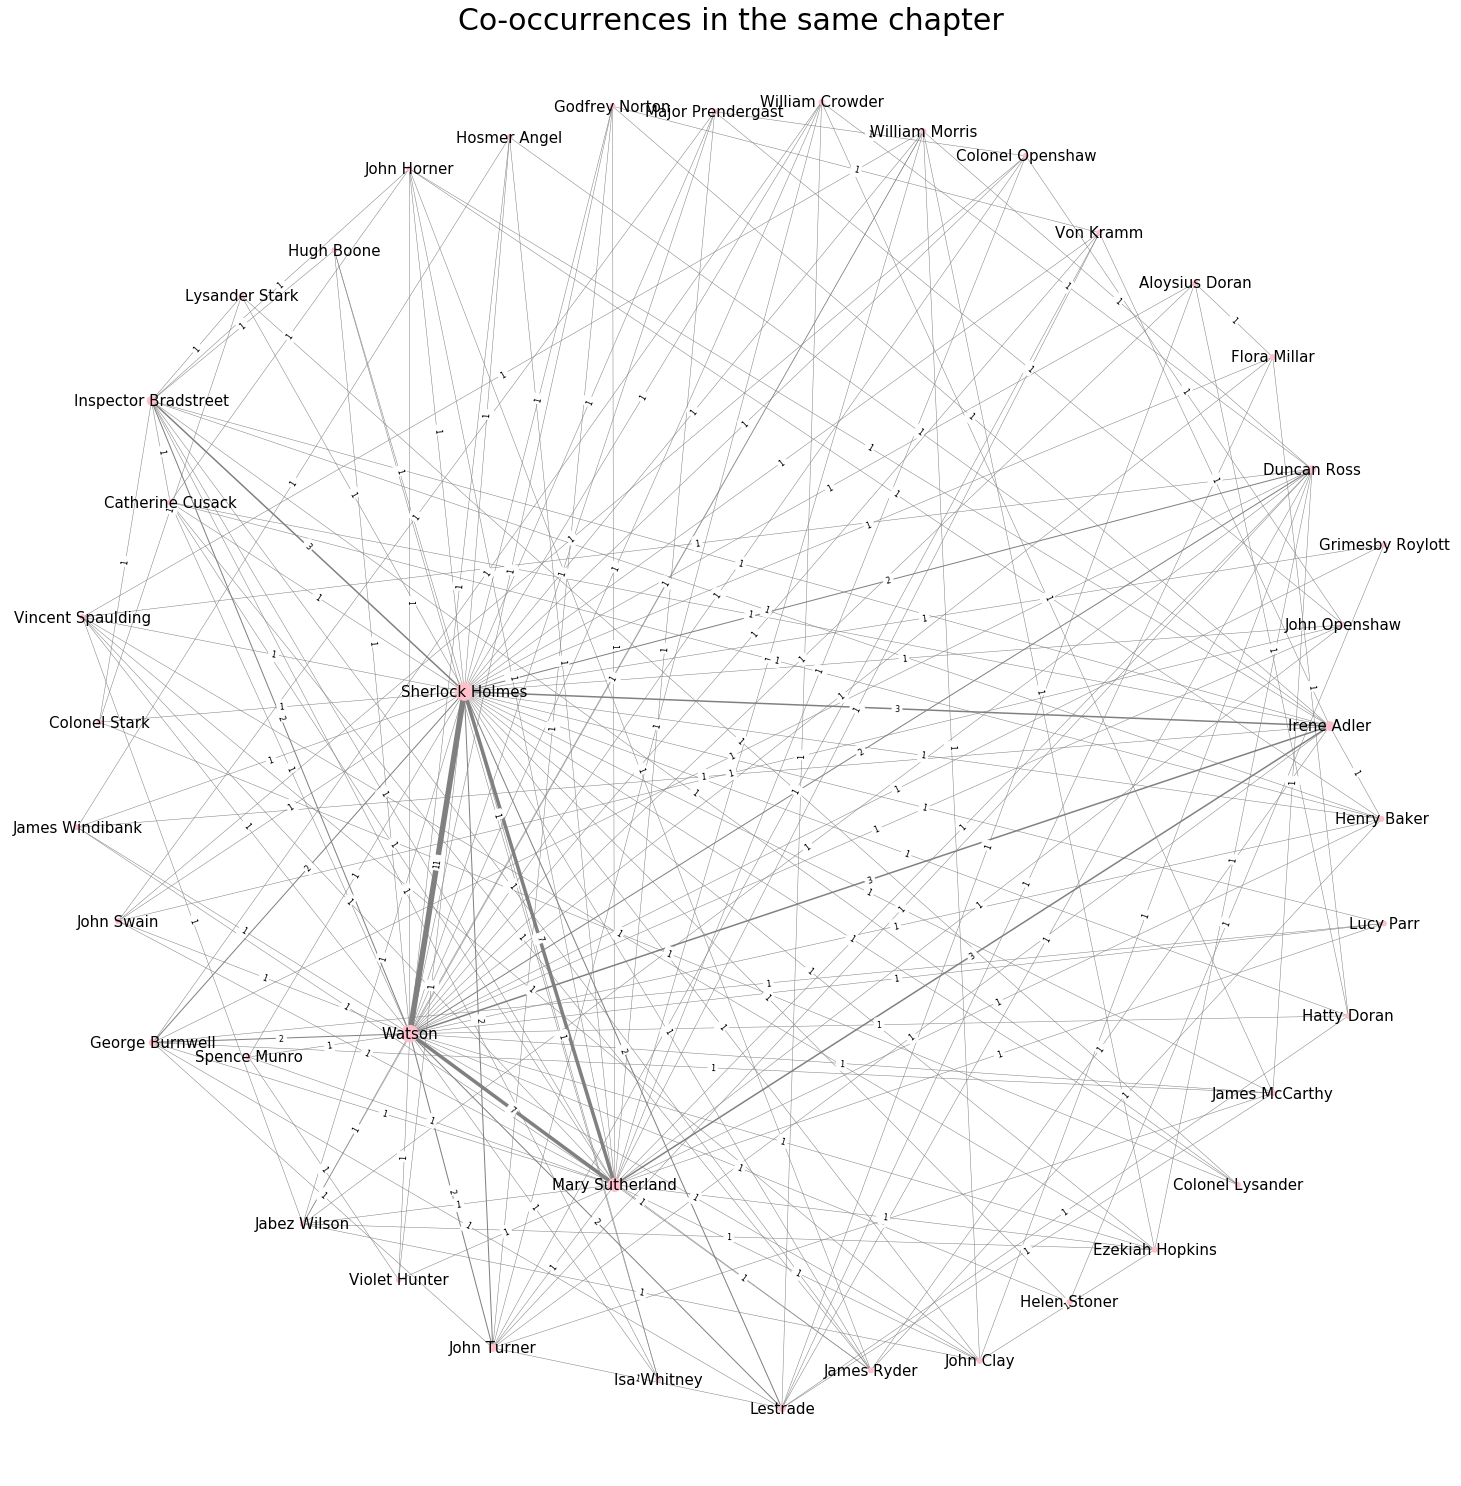

In [75]:
char_counter = dict(Counter([item for sublist in who_together for item in sublist]))
G = nx.Graph()
for one_page in who_together:
    if len(one_page) > 1: 
        edges = list(combinations(one_page, 2))   # possible combinations of pairs of characters mentioned on one page

        for i,j in edges:  
            if (i,j) in G.edges() or (j,i) in G.edges():   # adding weight to the edge, if exists
                G[i][j]['weight'] += 1    
            else:
                G.add_edge(i, j, weight = 1)   # creating edge between characters, if it does not exist yet

    elif one_page[0] not in G.nodes():  # if there is a single character, creating node for them, if it does not exist yet
        G.add_node(one_page[0])
        
sizes = [char_counter[name]*25 for name in list(G.nodes)]

plt.figure(figsize = (20,20)) 
pos = nx.spring_layout(G, k = 6, iterations = 100)
edge_width = [G[i][j]['weight']/2 for i,j in G.edges()]
nx.draw(G, pos, node_size = sizes, with_labels = True, font_size=15, node_color='pink', edge_color='gray', width=edge_width)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, font_size = 8)
plt.title("Co-occurrences in the same chapter", fontdict = {'fontsize' : 30})
plt.show()

As we can see, Watson didn't appear in one chapter! But surprisingly there is an other character that took part in as much as 7 chapters -- Mary Sutherland. However Lestrade, for example, whose mentions pro page were quite high, appears in only two chapters.

    Final remarks: there are still a few mistakes in character analysis and much more exceptions to include, but it will require much more time and manual checking. But I find this analysis already good enough, so I stop here.